In [1]:
!pip install tabulate
import numpy as np
import cv2
import math
from PIL import Image
import os
from tabulate import tabulate
from matplotlib import pyplot as plt

filename = "cameraman.tif"  # Replace with the path to your image file

# Get the file size in bytes
filesize = os.path.getsize(filename)

# Calculate the number of bits in the file
num_bits = filesize * 8

print("The image has", num_bits, "bits.")

# Defining Q matrix 
Q = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
              [12, 12, 14, 19, 26, 58, 60, 55],
              [14, 13, 16, 24, 40, 57, 69, 56],
              [14, 17, 22, 29, 51, 87, 80, 62],
              [18, 22, 37, 56, 68, 109, 103, 77],
              [24, 35, 55, 64, 81, 104, 113, 92],
              [49, 64, 78, 87, 103, 121, 120, 101],
              [72, 92, 95, 98, 112, 100, 103, 99]])



# Define the encoding 
def binary(n):
    binary_string = ''
    while(n/2 != 0):
        if n%2 == 0:
            binary_string = '0' + binary_string
        else:
            binary_string = '1' + binary_string
        n = int(n/2)
    return binary_string

def compress(image):
    """
    Compresses an input grayscale image using the JPEG algorithm.

    Args:
        image (numpy.ndarray): A grayscale image as a 2D numpy array.

    Returns:
        A string of bits representing the compressed image.
    """
    # Pad the image to be divisible by 8
    h, w = image.shape
    padded_h = (h + 7) // 8 * 8
    padded_w = (w + 7) // 8 * 8
    padded_image = np.zeros((padded_h, padded_w))
    padded_image[:h, :w] = image

    # Split the padded image into 8x8 blocks and apply the DCT to each block
    blocks = [padded_image[j:j+8, i:i+8] for (j, i) in np.ndindex(padded_h, padded_w) if j % 8 == 0 and i % 8 == 0]
    dct_blocks = [np.floor((cv2.dct(block.astype(np.float32)) / Q)+0.5) for block in blocks]
   
    # Lossless Encoding each Quantized DCT coefficient and encode the resulting quantized index
    bitstream = ''
    for dct_block in dct_blocks:
        for i in range(8):
            for j in range(8):
                index = int(dct_block[i, j])
                if index == 0:
                    bitstream = bitstream + '0'
                else:
                    power = math.floor(math.log2(abs(index))) + 1
                    prefix_code = ('1' * (power)) + '0'
                    if index < 0:
                        index = index+ (2**(power) - 1)
                        suffix_code = binary(index)
                        suffix_code = ('0' * (power - len(suffix_code))) + suffix_code 
                    else:
                        suffix_code = binary(index)
                    code = prefix_code + suffix_code
                    bitstream = bitstream + code
                bitstream += binary(index)

    return bitstream


def Quantized_DCT(image):
    """
    Compresses an input grayscale image using the JPEG algorithm.

    Args:
        image (numpy.ndarray): A grayscale image as a 2D numpy array.

    Returns:
        A string of bits representing the compressed image.
    """
    # Pad the image to be divisible by 8
    h, w = image.shape
    padded_h = (h + 7) // 8 * 8
    padded_w = (w + 7) // 8 * 8
    padded_image = np.zeros((padded_h, padded_w))
    padded_image[:h, :w] = image

    # Split the padded image into 8x8 blocks and apply the DCT to each block
    blocks = [padded_image[j:j+8, i:i+8] for (j, i) in np.ndindex(padded_h, padded_w) if j % 8 == 0 and i % 8 == 0]
    dct_blocks = [np.floor((cv2.dct(block.astype(np.float32)) / Q)+0.5) for block in blocks]
    return dct_blocks

def reconstruct_image(dct_blocks, Q):
    """
    Reconstructs an image from DCT coefficients by applying inverse DCT.

    Args:
        dct_blocks (list of numpy.ndarray): A list of DCT coefficient matrices.
        Q (numpy.ndarray): The quantization matrix.

    Returns:
        A 2D numpy array representing the reconstructed image.
    """
    # Inverse each DCT coefficient
    dequantized_blocks = [dct_block * Q for dct_block in dct_blocks]

    # Apply inverse DCT to each block and concatenate into a padded image
    padded_image = np.zeros((len(dct_blocks) // (image_w // 8) * 8, image_w))
    for i, dct_block in enumerate(dequantized_blocks):
        block = cv2.idct(dct_block.astype(np.float32))
        row = (i // (image_w // 8)) * 8
        col = (i % (image_w // 8)) * 8
        padded_image[row:row+8, col:col+8] = block

    # Remove the padding and return the image
    return padded_image[:image_h, :image_w]



# Computing MSE between Original & Reconstructed Images
def mse(original_image, reconstructed_image):
    mean_square_error = np.mean((original_image-reconstructed_image)**2)
    return mean_square_error









The image has 521920 bits.


In [2]:
# Load the image 
image = Image.open('cameraman.tif')
im = image
image.show()
image = np.array(image)
image_h, image_w = np.shape(image)

In [3]:
# Reonstructed Image
dct_blocks = Quantized_DCT(image)
reconstructed_img = reconstruct_image(dct_blocks, Q)
reconstructed_img_to_display = Image.fromarray(reconstructed_img,)
reconstructed_img_to_display.show()

In [4]:
# Image Compression 
bitstream = compress(image)

# Compression Ratio
No_of_bits = len(bitstream)
print("No. of bits in compressed format = ", len(bitstream))
print("No. of bits in original image = ", num_bits)
print("Size of Output file after compression is", No_of_bits/(1024*8),"KB")
compression_ratio = num_bits/No_of_bits
print("The Compression Ratio is ",compression_ratio)

# mse computation
print("Mean Square Error is", mse(image, reconstructed_img))

No. of bits in compressed format =  78616
No. of bits in original image =  521920
Size of Output file after compression is 9.5966796875 KB
The Compression Ratio is  6.638852142057597
Mean Square Error is 256.26692341723214


+-----------------------+---------------------------+---------------------+-----------+
|   Actual Size in bits |   Compressed Size in bits |   Compression Ratio |       MSE |
+=======================+===========================+=====================+===========+
|                521920 |                    124656 |             4.18688 |   44.5456 |
+-----------------------+---------------------------+---------------------+-----------+
|                521920 |                    103211 |             5.05683 |   78.9355 |
+-----------------------+---------------------------+---------------------+-----------+
|                521920 |                     93912 |             5.55754 |  106.239  |
+-----------------------+---------------------------+---------------------+-----------+
|                521920 |                     89479 |             5.83288 |  130.879  |
+-----------------------+---------------------------+---------------------+-----------+
|                521920 |       

Text(0.5, 1.0, 'Compression Ratio v/s MSE')

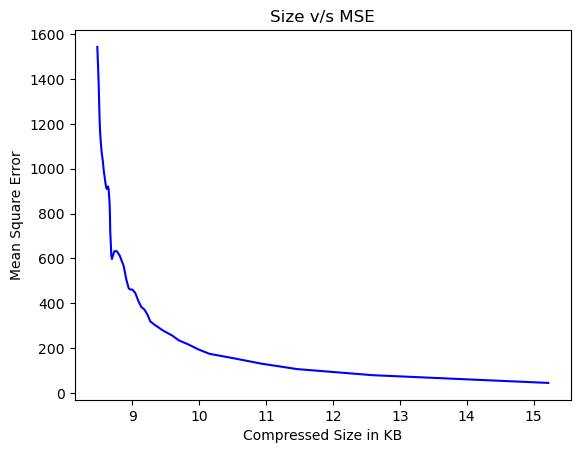

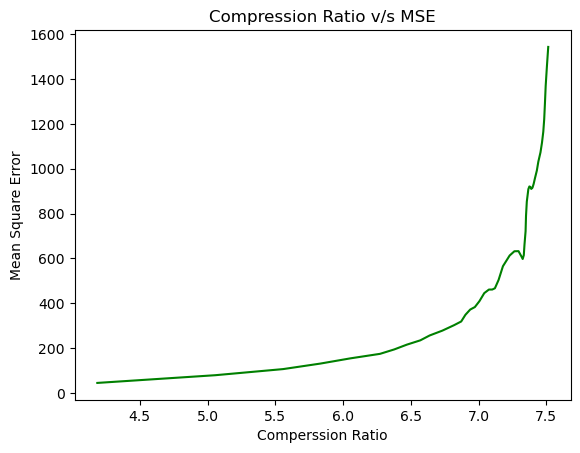

In [5]:


results = np.zeros((51,4))
for i in range(1, 52, 1):
# Define the quantization matrix
    Q = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
              [12, 12, 14, 19, 26, 58, 60, 55],
              [14, 13, 16, 24, 40, 57, 69, 56],
              [14, 17, 22, 29, 51, 87, 80, 62],
              [18, 22, 37, 56, 68, 109, 103, 77],
              [24, 35, 55, 64, 81, 104, 113, 92],
              [49, 64, 78, 87, 103, 121, 120, 101],
              [72, 92, 95, 98, 112, 100, 103, 99]])
    Q = i*Q
# Compression Ratio
    results[i-1,0] = num_bits
    bitstream = compress(image) 
    No_of_bits = len(bitstream)
    results[i-1,1] = No_of_bits
    compression_ratio = num_bits/No_of_bits
    results[i-1,2] = compression_ratio
    dct_blocks = Quantized_DCT(image)
    reconstructed_img = reconstruct_image(dct_blocks, Q)
    results[i-1,3] = mse(image, reconstructed_img)

# Tabulating Results
Results = results
results = list(results)
results = [['Actual Size in bits','Compressed Size in bits','Compression Ratio', 'MSE']] + results
print(tabulate(results,headers='firstrow', tablefmt='grid'))
      
# Plotting Results
plt.figure()
plt.plot(Results[:,1]/8192, Results[:,3], color='blue')
plt.xlabel('Compressed Size in KB')
plt.ylabel('Mean Square Error')
plt.title('Size v/s MSE')

# Plotting Results
plt.figure()
plt.plot(Results[:,2], Results[:,3], color='green')
plt.xlabel('Comperssion Ratio')
plt.ylabel('Mean Square Error')
plt.title('Compression Ratio v/s MSE')
    